# Plots for Paper
-- Irene Julca, April 2024

In [298]:
import argparse, glob
import sys,os
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from scipy.stats import mannwhitneyu
from scipy.stats import ranksums
from scipy.stats import kruskal
from scikit_posthocs import posthoc_dunn
from statsmodels.sandbox.stats.multicomp import multipletests
import matplotlib.colors
import math
import ete3, ete4

## functions

In [299]:
### General
  
def load_taxa(inFile):
    table = {}
    for line in open(inFile):
        line = line.strip()
        data = line.split('\t')
        table[data[0]] = data[1]#.split(';')[-1].strip()
    return table

def load_major_lin(inFile, tag='no'):
    table = {}
    for line in open(inFile):
        line = line.strip()
        data = line.split('\t')
        if tag == 'no':
            table[data[0]] = data[-1].split('; ')
        else:
            for e in data[-1].split('; '):
                table[e] = data[0]
    return table

def merge_data_sym_asym(data, clase):
    ds = pd.concat([data[i] for i,x in enumerate(clase) if x=='symmetric'], axis=0)
    da = pd.concat([data[i] for i,x in enumerate(clase) if x=='asymmetric'], axis=0)
    ds['symmetric']= True
    da['symmetric'] = False
    return pd.concat([ds, da],axis=0)
    
def clean_nan(df, column_name):
    df_cleaned = df.dropna(subset=[column_name])
    return df_cleaned

def get_node(row,t):
    n = t.get_common_ancestor(row.species, row.outgroup_species)
    node = t&row.species
    time = 0
    while node != n:
        time += node.dist
        node = node.up
    return time

def add_time_dataframe(dc, treeTime, pref2names): ####
    table = {'_'.join(pref2names[x].split(' ')):x for x in pref2names}
    t = ete3.Tree(treeTime, format=1)
    for leaf in t:
        leaf.name = table[leaf.name]
    leaves = t.get_leaf_names()
    dc = dc[(dc.species.isin(leaves)) & (dc.outgroup_species.isin(leaves))].copy() ## filtering out rows that do not have time
    dc['time'] = dc.apply(lambda row: get_node(row, t), axis=1)
    return dc
    
def add_time_interval(df, time_dict):
    
    def get_key_value(t, time_dict):
        for key, value in time_dict.items():
            if key[0] <= t <= key[1]:  # Check if the time falls within the range
                return key, value
        return None, None  # Return None if no match is found
    
    df[['interval', 'inum']] = df['time'].apply(lambda x: pd.Series(get_key_value(x, time_dict)))
    return df

def get_mannwhitneyu(list1, list2):
    man = mannwhitneyu(list1, list2)
    return man[1]

def format_pval(p):
    if p < 0.01:
        sn = np.format_float_scientific(p, precision=1, exp_digits=1)+"**"
    elif p < 0.05:
        sn = np.format_float_scientific(p, precision=1, exp_digits=1)+"*"
    else:
        sn = str(round(p,3))
    return sn

def load_categories(df):
    df_nn = df[(df.ldo_category == 'normal') & (df.mdo_category == 'normal') & (df.ldo_delta_exp_p > 0.05) & (df.mdo_delta_exp_p > 0.05)]
    df_ss = df[(df.ldo_category == 'short') & (df.ldo_delta_exp_p < 0.05) & (df.mdo_category == 'short') & (df.mdo_delta_exp_p < 0.05)]
    df_ll = df[(df.ldo_category == 'long') & (df.ldo_delta_exp_p < 0.05) & (df.mdo_category == 'long') & (df.mdo_delta_exp_p < 0.05)]
    df_nl = df[(df.ldo_category == 'normal') & (df.ldo_delta_exp_p > 0.05) & (df.mdo_category == 'long') & (df.mdo_delta_exp_p < 0.05)]
    df_sn = df[(df.ldo_category == 'short') & (df.ldo_delta_exp_p < 0.05) & (df.mdo_category == 'normal') & (df.mdo_delta_exp_p > 0.05)]
    df_sl = df[(df.ldo_category == 'short') & (df.ldo_delta_exp_p < 0.05) & (df.mdo_category == 'long') & (df.mdo_delta_exp_p < 0.05)]
    data = [df_nn,df_ss,df_ll,df_nl,df_sn,df_sl]
    return data

In [300]:
### Save the data in a standard format

structureH5File = 'structure/structure_results_FOLDSEEK.h5'

with pd.HDFStore(structureH5File, mode='r') as store:
    keys = store.keys()
    df_combined = pd.concat([store.get(key) for key in keys], ignore_index=True)

df_combined.to_csv('structure/structure_results_FOLDSEEK.csv.gz', index=False, compression='gzip')


### Duplication analysis

In [301]:
#### Input 
speciesFile = 'data/panther-18.0/species_tree.nhx'
structureFile = 'structure/structure_results_FOLDSEEK.csv.gz'

#### Output tables
pathTables = 'results/tables/'
majorLinFile = pathTables + 'major_lineages_sp.txt'
lin2catFile = pathTables+'lineages2categories.tsv'
lin2catPerFile = pathTables+'lineages2categories.per.tsv'
lin2catRankFile = pathTables+'lineages2categories.rank.tsv'

#### Output figures
pathPlots = 'results/plots/'
dupFigure1 = pathPlots +'histogram_familyrates.svg'  ## Supplementary Figure 1
dupFigure2 = pathPlots + 'bar_dups_categories.svg' ## Panel Figure 2
dupFigure3 = pathPlots + 'internl_terminal_dup.svg'

In [302]:
### Load the main dataframe
df = pd.read_csv(structureFile, low_memory=False)


In [303]:
data = load_categories(df)

### General Variables
categories = ['normal-normal', 'short-short', 'long-long', 'normal-long', 'short-normal', 'short-long'] 
clase = ['symmetric','symmetric','symmetric','asymmetric','asymmetric','asymmetric']
categories_dic = {'normal-normal':'symmetric', 'short-short':'symmetric', 'long-long':'symmetric',
            'normal-long':'asymmetric', 'short-normal':'asymmetric', 'short-long':'asymmetric',
            'short-normal':'asymmetric'}

print(f"Total number of duplications: {df.shape[0]}")
print(f"Average number of duplications per gene family: {df.fam_id.value_counts().mean()}")


Total number of duplications: 926814
Average number of duplications per gene family: 68.663061194251


In [304]:
##### Species tree, Creating major lineages files
groupLin = ['Protostomia', 'Deuterostomia', 'Fungi', 'Amoebozoa', 'Excavates',
            'Alveolata-Stramenopiles','Viridiplantae', 'Archaea', 'Eubacteria']
indLin = ['NEMVE','TRIAD','MONBE']
lineages = groupLin+indLin
dict_lineages = {x:set() for x in groupLin}
dict_lineages.update({x:set([x]) for x in indLin})

t = ete4.Tree(open(speciesFile))

for node in t.traverse('postorder'):
    props = node.props
    if 'S' in props:
        lin = props['S']
        if lin in dict_lineages:
            dict_lineages[lin].add(lin)
            for leaf in node:
                dict_lineages[lin].add(leaf.name)
            for n in node.traverse():
                info = n.props
                if 'S' in info:
                    name = info['S']
                    dict_lineages[lin].add(name)
i = 0
outfile = open(majorLinFile,'w')
for e in lineages:
    names = dict_lineages[e]
    species = [x for x in names if x.isupper()]
    string = e+'\t'+str(len(names))+'\t'+str(len(species))+'\t'+'; '.join(names)
    print(string,file=outfile)
    i += len(species)
print(f"Number of species analysed: {i}")
outfile.close()

internal_nodes = ['Bilateria', 'Eumetazoa', 'Metazoa-Choanoflagellida',
                  'Opisthokonts', 'Unikonts', 'Eukaryota', 'Bikonts',
                  'SAR/HA_supergroup', 'Archaea-Eukaryota', 'LUCA']
# ## Node 1: 'Bilateria'
# ## Node 2: 'Eumetazoa'
# ## Node 3: 'Metazoa-Choanoflagellida'
# ## Node 4: 'Opisthokonts'
# ## Node 5: 'Unikonts'
# ## Node 6: 'Eukaryota'
# ## Node 7: 'Bikonts'
# ## Node 8: 'SAR/HA_supergroup'
# ## Node 9: 'Archaea-Eukaryota'
# ## Node 10: 'LUCA'

Number of species analysed: 143


In [305]:
lineages_all = {x:dict_lineages[x] for x in dict_lineages}
lineages_all.update({x:[x] for x in internal_nodes})
outfile = open(lin2catFile,'w')
head = f"Taxa\t"+"\t".join(categories)
print(head,file=outfile)
for lin in lineages_all: #df.sp_tree_head.values
    names = lineages_all[lin]
    string = lin
    for d in data:   
        n = d[d['sp_tree_head'].isin(names)].shape[0]
        string+='\t'+str(n)
    print(string,file=outfile)
outfile.close()

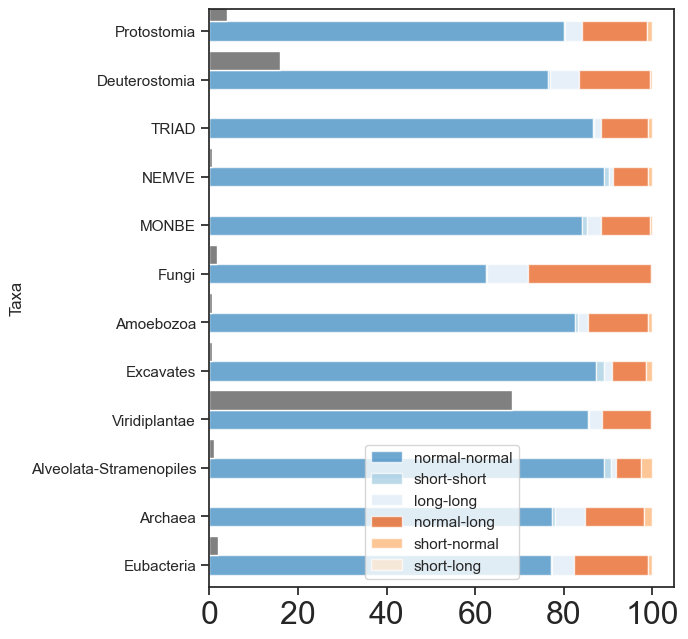

In [306]:
#### Plot of the categories ## Figure 2
lin_names = ['Protostomia', 'Deuterostomia','TRIAD','NEMVE','MONBE', 'Fungi', 'Amoebozoa', 'Excavates',
            'Viridiplantae','Alveolata-Stramenopiles','Archaea', 'Eubacteria']
lin_names.reverse()
df = pd.read_csv(lin2catFile, sep='\t', header=0)
df['total'] = df.sum(numeric_only=True, axis=1)
df['totalper']=df['total']*100/df['total'].sum()
df = df[df['Taxa'].isin(lineages) == True] ## remove the ones in internal nodes
df.sort_values(by=['Taxa'], key=lambda column: column.map(lambda e: lin_names.index(e)), inplace=True)
# print(df)

df2 = pd.DataFrame() ## dataframe of categories
for e in categories:
    df2[e] = df[e]*100/df['total']
df2['Taxa'] = df['Taxa']
df2.to_csv(path_or_buf=lin2catPerFile, sep='\t', header=True, index=False)

palette = ['#3182bdff','#9ecae1ff','#deebf7ff','#e6550dff','#fdae6bff','#fee6cec4']
bar_width = 0.4
bar_positions = range(len(df))
fig, ax = plt.subplots()
ax = df2.plot(x='Taxa', y=categories, kind='barh', stacked=True, color=palette, alpha=.7, ax=ax,
              figsize=(6, 7.5), width=bar_width)

ax.barh([p + bar_width for p in bar_positions],df['totalper'], bar_width, color='#808080ff', label='duplications')
plt.xticks(fontsize=23)
plt.savefig(dupFigure2, bbox_inches='tight')
plt.show()


In [307]:
lineages_all = {x:dict_lineages[x] for x in dict_lineages}
outfile = open(lin2catRankFile,'w')
head = f"Taxa\tRank\t"+"\t".join(categories)
print(head,file=outfile)
tbranch = []
ibranch = []
for lin in lineages_all: #df.sp_tree_head.values
    names = lineages_all[lin]
    terminal = [x for x in names if x.isupper() and x!='LUCA']
    internal = [x for x in names if x not in terminal]
    string2 = f"{lin}\tTerminal"
    string1 = f"{lin}\tInternal"
    for d in data:
        df2 = d[d['sp_tree_head'].isin(terminal)]
        df3 = d[d['sp_tree_head'].isin(internal)]
        n1 = df2.shape[0]
        n2 = df3.shape[0]
        term = df2.mdo_branch_length - df2.ldo_branch_length
        inte = df3.mdo_branch_length - df3.ldo_branch_length
        tbranch += list(term.values)
        ibranch += list(inte.values)
        string2+='\t'+str(n1)
        string1+='\t'+str(n2)
    print(string1,file=outfile)
    print(string2,file=outfile)
outfile.close()
print(np.mean(tbranch), np.mean(ibranch), get_mannwhitneyu(tbranch, ibranch))

0.13549137612431392 0.1583758116744469 0.0


Rank       Terminal   Internal
TotalPer  70.287425  29.712575
          symmetric  asymmetric
Rank                           
Terminal  86.723892   13.276108
Internal  79.699232   20.300768


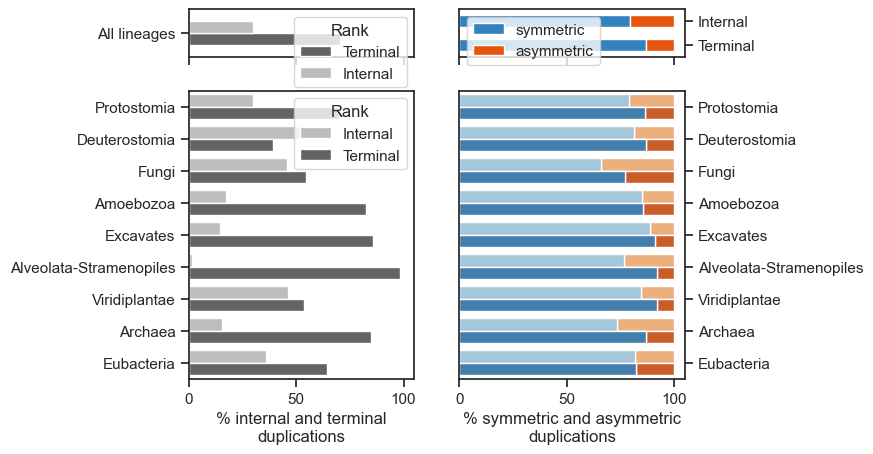

In [308]:
#### Create the plot Supplementary figure 3

lineages = ['Protostomia', 'Deuterostomia', 'Fungi', 'Amoebozoa', 'Excavates', ### we removed 'TRIAD', 'NEMVE','MONBE'
            'Viridiplantae','Alveolata-Stramenopiles','Archaea', 'Eubacteria']
lineages.reverse()
df = pd.read_csv(lin2catRankFile, sep='\t', header=0) 
df = df[df['Taxa'].isin(lineages) == True] ### we removed 'TRIAD', 'NEMVE','MONBE'

# calculate the total percentage of duplications
for index, row in df.iterrows():
    taxa = df['Taxa'].values[index]
    df2 = df[df['Taxa'] == taxa]
    total = df2[categories].sum()  # getting the total number of duplications per lineage
    num = row.values[2:]
    df.at[index, 'TotalPer'] = np.sum(num)*100/total.sum()
    sym = (row[['normal-normal','short-short','long-long']].sum())*100/np.sum(num)
    asym = (row[['normal-long','short-normal','short-long']].sum())*100/np.sum(num)
    df.at[index,'symmetric'] = sym
    df.at[index,'asymmetric'] = asym + sym

palettedup = ['#bdbdbd','#636363']
palettecata = ['#fdae6bff','#e6550dff']
palettecats = ['#9ecae1ff','#3182bdff']  
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, gridspec_kw={'height_ratios': [1, 6]})
axes = axes.flatten()
sns.barplot(data=df, x="TotalPer", y="Taxa", hue="Rank", palette=palettedup, ax=axes[2])
sns.barplot(data=df, x='asymmetric', y='Taxa', hue='Rank', palette=palettecata, legend=False, ax=axes[3])
sns.barplot(data=df, x='symmetric', y='Taxa', hue='Rank', palette=['white','white'], legend=False, ax=axes[3])
sns.barplot(data=df, x='symmetric', y='Taxa', hue='Rank', palette=palettecats, legend=False, ax=axes[3])

dfper = df[['Rank','TotalPer']].groupby(by=['Rank']).mean().T
dfper = dfper[['Terminal','Internal']]
print(dfper)
dfper.plot(kind='barh', color=['#636363','#bdbdbd'], ax=axes[0])
axes[0].set_yticklabels(['All lineages'])
dfcat = df[['Rank','symmetric','asymmetric']].groupby(by=['Rank']).mean()
dfcat = dfcat.reindex(['Terminal','Internal'])
dfcat['asymmetric'] = 100 - dfcat['symmetric']
dfcat.plot(kind='barh', color=['#3182bdff','#e6550dff'], stacked=True, ax=axes[1])
print(dfcat)

### labels and ticks
axes[1].yaxis.tick_right()
axes[3].yaxis.tick_right()
axes[1].set_ylabel('')
axes[2].set_ylabel('')
axes[3].set_ylabel('')
axes[2].set_xlabel('% internal and terminal\nduplications') #re.sub("(.{10})", "\\1\n", label, 0, re.DOTALL)
axes[3].set_xlabel('% symmetric and asymmetric\nduplications')
plt.savefig(dupFigure3, bbox_inches='tight')

plt.show()

### Structure analysis

In [309]:
### Functions
sns.set(context='notebook', style='ticks', palette='deep', font='arial', font_scale=1.5, color_codes=False, rc=None)

def get_structure_out(data, clase, outfigure):
    dc = merge_data_sym_asym(data, clase)
    dc = clean_nan(dc, 'struct_ldo_mdo_lddt')
    values = [list(dc[dc.symmetric]['struct_ldo_mdo_lddt'].values), list(dc[~dc.symmetric]['struct_ldo_mdo_lddt'].values)]

    print('symmetric mean:',np.mean(values[0]), 'asymmetric mean:',np.mean(values[1]))
    print('symmetric median:',np.median(values[0]), 'asymmetric median:',np.median(values[1]))
    
    p = format_pval(get_mannwhitneyu(values[0],values[1]))
    ax = sns.boxplot(data=values, fliersize=0, palette=['#9ecae1ff','#fdae6bff'])
    plt.xticks([0,1], ['Symmetric','Asymmetric'])
    plt.ylabel('Structural similarity\n(Foldseek LDDT)')
    x1,x2 = 0,1
    y, h, col, z = 1.05, 0.05, 'k', 0.03
    plt.plot([x1, x1, x2, x2], [y-z, y+h-z, y+h-z, y-z], lw=0.5, c=col)
    plt.text((x1+x2)*.5, y+h-z, str(p), ha='center', va='bottom', color=col)#, fontsize=14)
    plt.savefig(outfigure, bbox_inches='tight')
    plt.show()

def plot_subplots_line_structure(df, pref2names, time_dic, majorlin, outfigname): ####Modifying this part, Here
    label_dic = {str(v):str(k[0])+'\n'+str(k[1]) for k, v in time_dic.items()}
    palette = ['#3182bdff','#e6550dff']
    df = clean_nan(df, 'struct_ldo_out_lddt')
    df = clean_nan(df, 'struct_mdo_out_lddt')
    sdf = df[df.symmetric].copy()
    adf = df[~df.symmetric].copy()
    ## Stats:
    psy = get_mannwhitneyu(list(sdf['struct_ldo_out_lddt'].values),list(sdf['struct_mdo_out_lddt'].values))
    pasy = get_mannwhitneyu(adf['struct_ldo_out_lddt'].values,adf['struct_mdo_out_lddt'].values)
    print(f"p-val for symmetric: {psy} and p-val for asymmetric: {pasy}")
    print(f"mean symmetric: {np.mean(list(sdf['struct_ldo_out_lddt'].values))} {np.mean(list(sdf['struct_mdo_out_lddt'].values))}")
    print(f"mean asymmetric: {np.mean(adf['struct_ldo_out_lddt'].values)} {np.mean(adf['struct_mdo_out_lddt'].values)}")
    
    ## Figures:
    plt.figure(figsize=(8, 4))
    ax = sns.lineplot(data=sdf, x="inum", y="struct_ldo_out_lddt", markers=False, errorbar=('ci', 95), color=palette[0], dashes=(2,3))
    ax = sns.lineplot(data=sdf, x="inum", y="struct_mdo_out_lddt", markers=False, errorbar=('ci', 95), color=palette[0], dashes=(3,0))
    ax = sns.lineplot(data=adf, x="inum", y="struct_ldo_out_lddt", markers=False, errorbar=('ci', 95), color=palette[1], dashes=(2,3))
    ax = sns.lineplot(data=adf, x="inum", y="struct_mdo_out_lddt", markers=False, errorbar=('ci', 95), color=palette[1], dashes=(3,0))
    
    x1,x2 = df['inum'].min(), df['inum'].max()
    plt.xlim(x2+0.5, x1-0.5)
    ticks = [item.get_text() for item in ax.get_xticklabels()]
    new_ticks = [label_dic[x] if x in label_dic else x for x in ticks]
    ax.set_xticklabels(new_ticks)
    ax.set_ylabel('Structural similarity\n(Foldseek LDDT)')
    ax.set_xlabel('Time interval (MYA)')
    plt.savefig(outfigname+'_all.svg')
    plt.show()

    ### Lineages
    lineages = ['Protostomia', 'Deuterostomia','TRIAD','NEMVE','MONBE', 'Fungi', 'Amoebozoa', 'Excavates',
                'Viridiplantae','Alveolata-Stramenopiles','Archaea', 'Eubacteria']
    df['Mlineages'] = df['species'].map(majorlin)
    lineages_df = set(df['Mlineages'].values)
    sdf = df[df.symmetric].copy()
    adf = df[~df.symmetric].copy()
    fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(16,18), sharex=True, sharey=True)
    axes = axes.flatten()
    i = 0
    for lin in lineages:
        if lin in lineages_df:
            df2 = df[df['Mlineages'] == lin]
            sns.lineplot(data=sdf[sdf['Mlineages']==lin], x="inum", y="struct_ldo_out_lddt", ax=axes[i], markers=False, errorbar=('ci', 95), color=palette[0], dashes=(2,3))
            sns.lineplot(data=sdf[sdf['Mlineages']==lin], x="inum", y="struct_mdo_out_lddt", ax=axes[i],markers=False, errorbar=('ci', 95), color=palette[0], dashes=(3,0))
            sns.lineplot(data=adf[adf['Mlineages']==lin], x="inum", y="struct_ldo_out_lddt", ax=axes[i],markers=False, errorbar=('ci', 95), color=palette[1], dashes=(2,3))
            sns.lineplot(data=adf[adf['Mlineages']==lin], x="inum", y="struct_mdo_out_lddt", ax=axes[i],markers=False, errorbar=('ci', 95), color=palette[1], dashes=(3,0))
            axes[i].set_title(lin)
            axes[i].set_ylabel('Structural similarity\n(Foldseek LDDT)')
            axes[i].set_xlabel('Time interval (MYA)')
            i +=1
    plt.xlim(x2+0.5, x1-0.5)     
    plt.setp(axes, xticklabels=new_ticks)
    plt.savefig(outfigname+'_lineages.svg', bbox_inches='tight')
    plt.show()

#### Paul comment sequence similarity and divergence
def plot_subplots_line_structure2(df, pref2names, time_dic, outfigname): 
    label_dic = {str(v):str(k[0])+'\n'+str(k[1]) for k, v in time_dic.items()}
    palette = ['#3182bdff','#e6550dff']
    sdf = df[df.symmetric].copy()
    adf = df[~df.symmetric].copy()
    
    plt.figure(figsize=(8, 4))
    ax = sns.lineplot(data=sdf, x="inum", y="struct_ldo_mdo_lddt", markers=False, errorbar=('ci', 95), color=palette[0], dashes=(2,3))
    ax = sns.lineplot(data=adf, x="inum", y="struct_ldo_mdo_lddt", markers=False, errorbar=('ci', 95), color=palette[1], dashes=(2,3))
    
    x1,x2 = df['inum'].min(), df['inum'].max()
    plt.xlim(x2+0.5, x1-0.5)
    ticks = [item.get_text() for item in ax.get_xticklabels()]
    new_ticks = [label_dic[x] if x in label_dic else x for x in ticks]
    ax.set_xticklabels(new_ticks)
    ax.set_ylabel('Structural similarity\n(Foldseek LDDT)')
    ax.set_xlabel('Time interval (MYA)')
    plt.savefig(outfigname)
    plt.show()


In [310]:
#### Input 
pathTables = 'results/tables/'
structureFile = 'structure/structure_results_FOLDSEEK.csv.gz'
majorLinFile = pathTables + 'major_lineages_sp.txt'
prefFile = pathTables+ 'mnemo2name.tsv'
panterTimeFile = pathTables+'species_panther.nwk'

#### Output tables
structTable1 = pathTables +'outgroup_structure.tsv'

#### Output figures
pathPlots = 'results/plots/'
structfig1 = pathPlots+'lddt_paralgos.svg'
structfig2 = pathPlots+'lddt_outgroup'
structfig3 = pathPlots+'lddt_paralogs_time.svg'

symmetric mean: 0.8376230473581409 asymmetric mean: 0.6979147456723388
symmetric median: 0.8583 asymmetric median: 0.7162


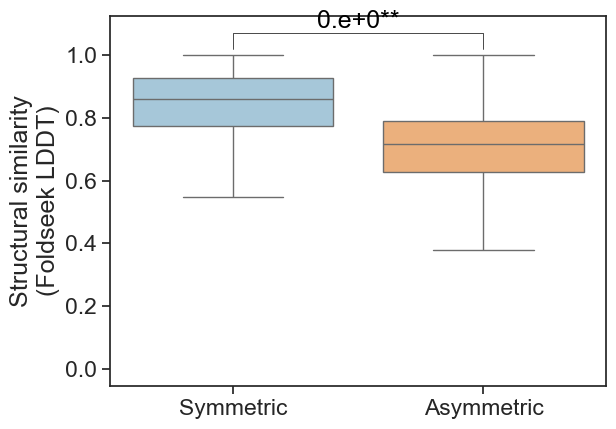

In [311]:
## Create the table and panel A of Figure 3
get_structure_out(data, clase, structfig1)


In [312]:
pref2names = load_taxa(prefFile)
dc = merge_data_sym_asym(data, clase)
dc = clean_nan(dc, 'struct_ldo_mdo_lddt')
### Add time to the table
dc_time = add_time_dataframe(dc, panterTimeFile, pref2names)

In [313]:
print(dc_time.head())

   fam_id  fam_tail_idx  sp_tree_edge            sp_tree_tail   sp_tree_head  \
0   10003           223           215  Bryophyta-Tracheophyta   Tracheophyta   
1   10015           632           215  Bryophyta-Tracheophyta   Tracheophyta   
2   10015           634           238            Tracheophyta  Magnoliophyta   
3   10015           634           238            Tracheophyta  Magnoliophyta   
4   10015           634           238            Tracheophyta  Magnoliophyta   

   ldo_fam_head_idx  mdo_fam_head_idx  ldo_branch_length  mdo_branch_length  \
0               309               225              0.147              0.292   
1              1684               634              0.081              0.353   
2               893               636              0.292              0.381   
3               893               799              0.292              0.396   
4               893               888              0.292              0.641   

   expected_branch_length  ...  species  ldo

0.49668 4250.08226


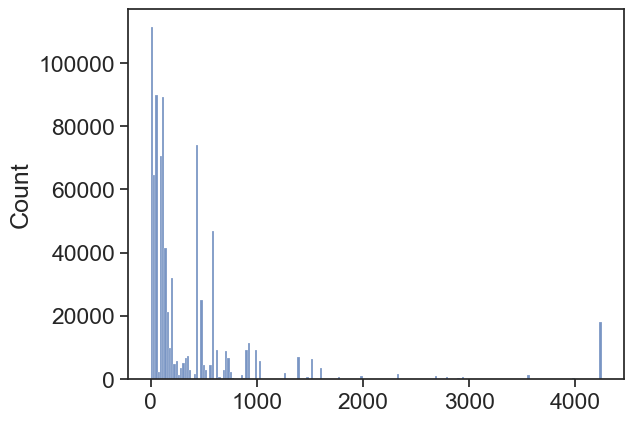

In [314]:
### create the intervals of time
times = sorted(list(dc_time['time'].values))
print(times[0],times[-1])
sns.histplot(times, bins=200)  ### most of the times are in the range: 0-1000
plt.show()

In [315]:
intervals = [(x,x+200-1) for x in range(0,1000,200)]+[(x,x+1000-1) for x in range(1000,3000,1000)]+[(3000,4300)]
print(intervals)
time_dict = {x:y+1 for y,x in enumerate(intervals)}

[(0, 199), (200, 399), (400, 599), (600, 799), (800, 999), (1000, 1999), (2000, 2999), (3000, 4300)]


In [316]:
### Add time interval to file
dc_trange = add_time_interval(dc_time, time_dict)
print(dc_trange.head())

   fam_id  fam_tail_idx  sp_tree_edge            sp_tree_tail   sp_tree_head  \
0   10003           223           215  Bryophyta-Tracheophyta   Tracheophyta   
1   10015           632           215  Bryophyta-Tracheophyta   Tracheophyta   
2   10015           634           238            Tracheophyta  Magnoliophyta   
3   10015           634           238            Tracheophyta  Magnoliophyta   
4   10015           634           238            Tracheophyta  Magnoliophyta   

   ldo_fam_head_idx  mdo_fam_head_idx  ldo_branch_length  mdo_branch_length  \
0               309               225              0.147              0.292   
1              1684               634              0.081              0.353   
2               893               636              0.292              0.381   
3               893               799              0.292              0.396   
4               893               888              0.292              0.641   

   expected_branch_length  ...  mdo_gene  ou

p-val for symmetric: 0.0 and p-val for asymmetric: 0.0
mean symmetric: 0.8472773152522513 0.8285580510599211
mean asymmetric: 0.819119493967109 0.7069512765683371


/tmp/ipykernel_5994/2557615406.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_ticks)


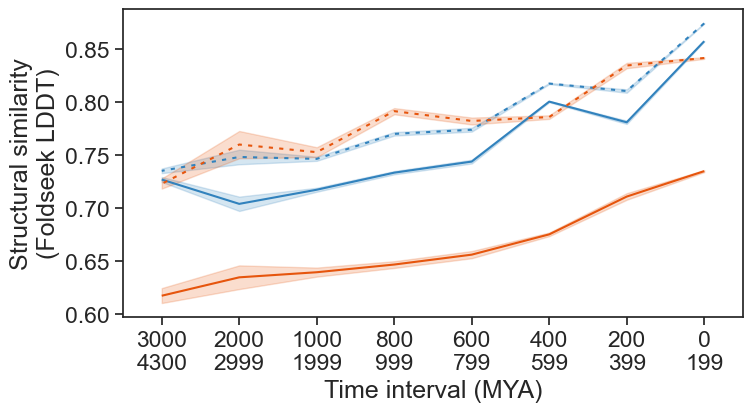

/tmp/ipykernel_5994/2557615406.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.setp(axes, xticklabels=new_ticks)
/tmp/ipykernel_5994/2557615406.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.setp(axes, xticklabels=new_ticks)
/tmp/ipykernel_5994/2557615406.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.setp(axes, xticklabels=new_ticks)
/tmp/ipykernel_5994/2557615406.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.setp(axes, xticklabels=new_ticks)
/tmp/ipykernel_5994/2557615406.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.setp

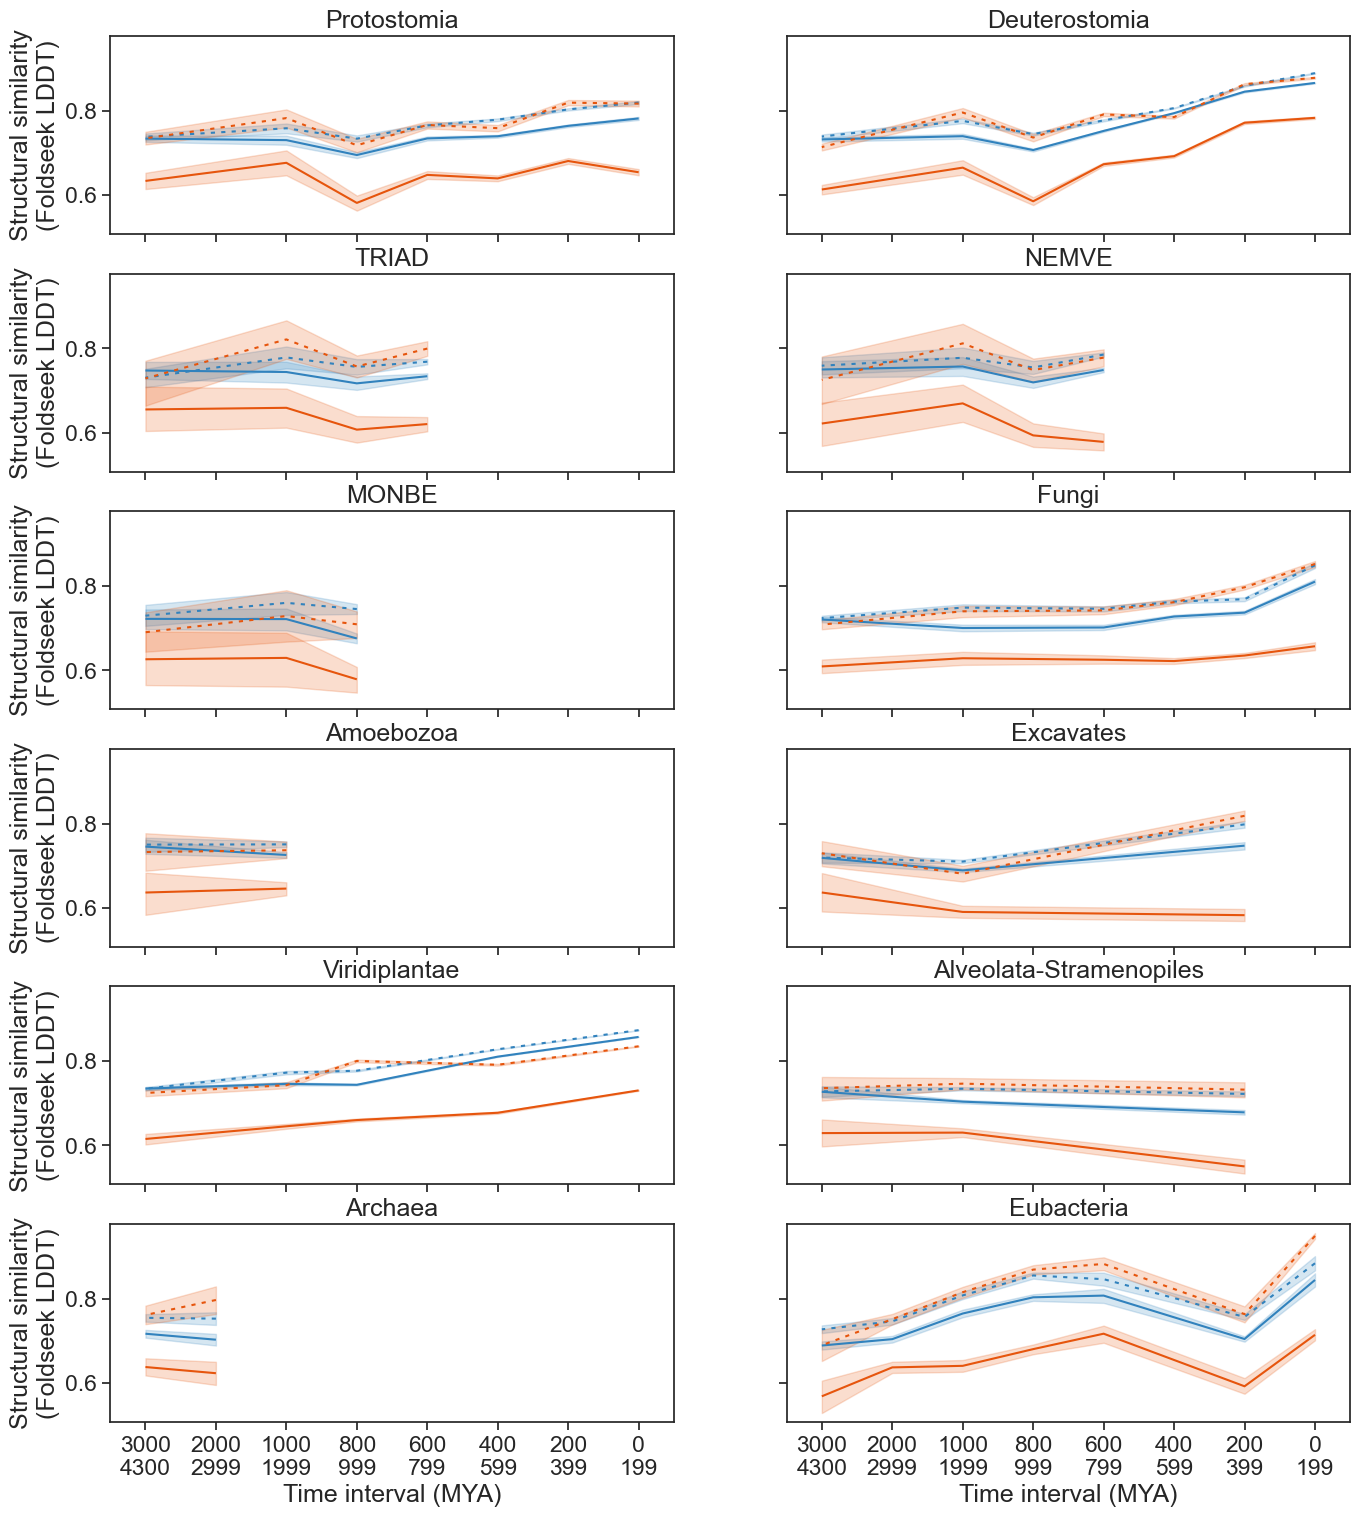

In [317]:
### Line plot, panel b of Figure 3
majorlin = load_major_lin(majorLinFile, 'inv')
plot_subplots_line_structure(dc_trange, pref2names, time_dict, majorlin, structfig2)


/tmp/ipykernel_5994/2557615406.py:95: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_ticks)


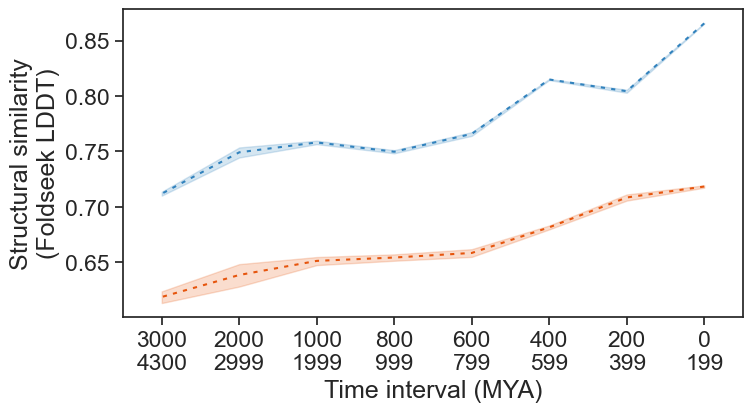

In [318]:
### Paul comment sequence divergence and structural divergence

plot_subplots_line_structure2(dc_trange, pref2names, time_dict, structfig3)

### PCC and TAU analysis

In [346]:
#####################
##### PCC plots #####
#####################

def plot_subplots_barplot(df, outname):
    df = clean_nan(df, 'pcc_stat')
    palette = ['#3182bdff','#e6550dff']
    categories = ['symmetric','asymmetric']
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6,4), sharex=True, sharey=True)
    axes = axes.flatten()
    samples = ['Animals','Plants']
    i,j = 0,1.1
    for x,tag in enumerate(samples):
        df2 = df[df.sp_group == tag]
        values = [df2[df2.symmetric]['pcc_stat'].values, df2[~df2.symmetric]['pcc_stat'].values]
        print(tag,'median:', np.median(values[0]), np.median(values[1]))
        p = format_pval(get_mannwhitneyu(values[0], values[1]))
        sns.boxplot(data=values, saturation=0.7, ax=axes[x], fliersize=0, palette=palette)
        x1,x2 = 0,i+1
        y, h, col, z = j+0.04, 0.05+i/4, 'k', 0.03
        axes[x].plot([x1, x1, x2, x2], [y-z, y+h-z, y+h-z, y-z], lw=0.5, c=col)
        axes[x].text((x1+x2)*.5, y+h-z, p, ha='center', va='bottom', color=col)#, fontsize=8)
        name = tag
        axes[x].set_title(name)
        axes[x].set_ylim(-1, 1.5) ## Fig1 1.6
        ticks_to_keep = axes[x].get_yticks()[:5] ### remove some yticks
        axes[x].set_yticks(ticks_to_keep)
        axes[x].set_ylabel('Expression similarity (PCC)')
        axes[x].set_xticks([0,1], categories, rotation=45, ha='right')
    plt.savefig(outname, bbox_inches='tight')
    plt.show()

def plot_subplots_barplot_species(df, outname, taxa2name):
    sns.set(context='notebook', style='ticks', palette='deep', font='arial', font_scale=1, color_codes=False, rc=None)
    df = clean_nan(df, 'pcc_stat')
    palette = ['#3182bdff','#e6550dff']
    categories = ['symmetric','asymmetric']
    fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(15,16), sharex=True, sharey=True)
    axes = axes.flatten()
    plants, animals = sorted(list(set(df[df.sp_group == 'Plants'].speciesF.values))),sorted(list(set(df[df.sp_group == 'Animals'].speciesF.values)))
    i,j = 0,1.1
    for x,tag in enumerate(plants+animals):
        df2 = df[df.speciesF == tag]
        values = [df2[df2.symmetric]['pcc_stat'].values, df2[~df2.symmetric]['pcc_stat'].values]
        p = format_pval(get_mannwhitneyu(values[0], values[1]))
        sns.boxplot(data=values, saturation=0.7, ax=axes[x], fliersize=0, palette=palette)
        x1,x2 = 0,i+1
        y, h, col, z = j+0.04, 0.05+i/4, 'k', 0.03
        axes[x].plot([x1, x1, x2, x2], [y-z, y+h-z, y+h-z, y-z], lw=0.5, c=col)
        axes[x].text((x1+x2)*.5, y+h-z, p, ha='center', va='bottom', color=col)#, fontsize=8)
        name = taxa2name[tag].split(' ')[0][0]+'. '+taxa2name[tag].split(' ')[1]
        axes[x].set_title(name, style='italic', size=14)
        axes[x].set_ylim(-1, 1.5) ## Fig1 1.6
        ticks_to_keep = axes[x].get_yticks()[:5] ### remove some yticks
        axes[x].set_yticks(ticks_to_keep)
        axes[x].set_ylabel('Expression similarity (PCC)')
        axes[x].set_xticks([0,1], categories, rotation=45, ha='right')
        if tag in animals:
            axes[x].set_facecolor('lightgray')
    plt.savefig(outname, bbox_inches='tight')
    plt.show()

def plot_subplots_barplot_nodes(df, outname):
    sns.set(context='notebook', style='ticks', palette='deep', font='arial', font_scale=1.5, color_codes=False, rc=None)
    df = clean_nan(df, 'pcc_stat')
    palette = ['#3182bdff','#e6550dff']
    categories = ['symmetric','asymmetric']
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10,4), sharex=True, sharey=True)
    axes = axes.flatten()
    i,j = 0,1.1
    for x in range(0,4):
        if x <2:
            df2 = df[df.sp_group == 'Plants']
        else:
            df2 = df[df.sp_group == 'Animals']
        if x % 2 == 0:
            df2 = df2[df2.node_type == False] ### internal nodes
            name = 'Internal'
        else:
            df2 = df2[df2.node_type == True] ### terminal nodes
            name = 'Terminal'
        values = [df2[df2.symmetric]['pcc_stat'].values, df2[~df2.symmetric]['pcc_stat'].values]
        print(name,'median:', np.median(values[0]), np.median(values[1]))
        p = format_pval(get_mannwhitneyu(values[0], values[1]))
        sns.boxplot(data=values, saturation=0.7, ax=axes[x], fliersize=0, palette=palette)
        x1,x2 = 0,i+1
        y, h, col, z = j+0.04, 0.05+i/4, 'k', 0.03
        axes[x].plot([x1, x1, x2, x2], [y-z, y+h-z, y+h-z, y-z], lw=0.5, c=col)
        axes[x].text((x1+x2)*.5, y+h-z, p, ha='center', va='bottom', color=col)#, fontsize=8)
        axes[x].set_title(name)
        axes[x].set_ylim(-1, 1.5) ## Fig1 1.6
        ticks_to_keep = axes[x].get_yticks()[:5] ### remove some yticks
        axes[x].set_yticks(ticks_to_keep)
        axes[x].set_ylabel('Expression similarity (PCC)')
        axes[x].set_xticks([0,1], categories, rotation=45, ha='right')
    plt.savefig(outname, bbox_inches='tight')
    plt.show()


    
###################
#### TAU plots ####
###################

def plot_subplots_violinplot(df, outname): 
    df = clean_nan(df, 'tauV')
    palette = ['#3182bdff','#e6550dff']
    categories = ['symmetric','asymmetric']
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6,4), sharex=True, sharey=True) 
    axes = axes.flatten()
    samples = ['Animals','Plants']
    for x,tag in enumerate(samples):
        df2 = df[df.sp_group == tag]
        values = [df2[df2.symmetric]['tauV'].values, df2[~df2.symmetric]['tauV'].values]
        p = format_pval(get_mannwhitneyu(values[0], values[1]))
        print(f"{tag} p-va= {p}")
        sns.violinplot(data=values, palette=palette, ax=axes[x], split=True, density_norm="width")
        name = tag
        axes[x].set_title(name +'\n($\it{p}$='+str(p)+')')
        axes[x].set_ylim(-1, 1.5) ## Fig1 1.6
        ticks_to_keep = axes[x].get_yticks()[:5] ### remove some yticks
        axes[x].set_yticks(ticks_to_keep)
        axes[x].set_ylabel('Tissue specificity difference\n(delta TAU)')
        axes[x].set_xticks([0,1], categories, rotation=45, ha='right')
    plt.savefig(outname, bbox_inches='tight')
    plt.show()
    
def plot_subplots_violinplot_species(df, outname, taxa2name):
    sns.set(context='notebook', style='ticks', palette='deep', font='arial', font_scale=1.2, color_codes=False, rc=None)
    df = clean_nan(df, 'tauV')
    palette = ['#3182bdff','#e6550dff']
    categories = ['symmetric','asymmetric']
    fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(15,24), sharex=True, sharey=True) 
    axes = axes.flatten()
    plants, animals = sorted(list(set(df[df.sp_group == 'Plants'].speciesF.values))),sorted(list(set(df[df.sp_group == 'Animals'].speciesF.values)))
    for x,tag in enumerate(plants+animals):
        df2 = df[df.speciesF == tag]
        values = [df2[df2.symmetric]['tauV'].values, df2[~df2.symmetric]['tauV'].values]
        p = format_pval(get_mannwhitneyu(values[0], values[1]))
        sns.violinplot(data=values, palette=palette, ax=axes[x], split=True, density_norm="width")
        name = taxa2name[tag].split(' ')[0][0]+'. '+taxa2name[tag].split(' ')[1]
        axes[x].set_title(f"{name}\n(p={p})", style='italic')
        axes[x].set_ylim(-1, 1.5) ## Fig1 1.6
        ticks_to_keep = axes[x].get_yticks()[:5] 
        axes[x].set_yticks(ticks_to_keep)
        axes[x].set_ylabel('Tissue specificity difference\n(delta TAU)')
        axes[x].set_xticks([0,1], categories, rotation=45, ha='right')
        if tag in animals:
            axes[x].set_facecolor('lightgray')
    plt.savefig(outname, bbox_inches='tight')
    plt.show()

def plot_subplots_violinplot_nodes(df, outname):
    sns.set(context='notebook', style='ticks', palette='deep', font='arial', font_scale=1.5, color_codes=False, rc=None)
    df = clean_nan(df, 'tauV')
    palette = ['#3182bdff','#e6550dff']
    categories = ['symmetric','asymmetric']
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10,4), sharex=True, sharey=True) 
    axes = axes.flatten()
    for x in range(0,4):
        if x <2:
            df2 = df[df.sp_group == 'Plants']
        else:
            df2 = df[df.sp_group == 'Animals']
        if x % 2 == 0:
            df2 = df2[df2.node_type == False] ### internal nodes
            name = 'Internal'
        else:
            df2 = df2[df2.node_type == True] ### terminal nodes
            name = 'Terminal'
        values = [df2[df2.symmetric]['tauV'].values, df2[~df2.symmetric]['tauV'].values]
        p = format_pval(get_mannwhitneyu(values[0], values[1]))
        print(f"{name} p-va= {p}")
        sns.violinplot(data=values, palette=palette, ax=axes[x], split=True, density_norm="width")
        axes[x].set_title(name +'\n($\it{p}$='+str(p)+')')
        axes[x].set_ylim(-1, 1.5) ## Fig1 1.6
        ticks_to_keep = axes[x].get_yticks()[:5] ### remove some yticks
        axes[x].set_yticks(ticks_to_keep)
        axes[x].set_ylabel('Tissue specificity difference\n(delta TAU)')
        axes[x].set_xticks([0,1], categories, rotation=45, ha='right')
    plt.savefig(outname, bbox_inches='tight')
    plt.show()



In [347]:
### inFiles
pathTables = 'results/tables/'
pathPlots = 'results/plots/'
pccFilePlant = 'results/correlation/plant_specific.h5'
pccFileAnimal = 'results/correlation/animal_maincat.h5'
prefFile = pathTables+ 'mnemo2name.tsv'
outFilePlant = 'results/outgroup_correlation/plant_specific.h5'
outFileAnimal = 'results/outgroup_correlation/animal_maincat.h5'
panterTimeFile = pathTables+'species_panther.nwk'

### OutFiles
outfig1 = pathPlots+'pcc_all.svg' ## Panel A Figure 4
outfig2 = pathPlots+'tau_all.svg'
outfig3 = pathPlots+'pcc_species.svg'
outfig4 = pathPlots+'tau_species.svg'
outfig5 = pathPlots+'pcc_nodes.svg'
outfig6 = pathPlots+'tau_nodes.svg'
outfig7 = pathPlots+'pcc_outgroup'
outfig8 = pathPlots+'tau_outgroup'

outTablepcc = pathTables+'outgroup_pcc.tsv'
outTabletau = pathTables+'outgroup_tau.tsv'


In [348]:
## Load data
df_exp_p = get_data_h5(pccFilePlant, 'Plants')
df_exp_a = get_data_h5(pccFileAnimal, 'Animals')
df = pd.concat([df_exp_p,df_exp_a],axis=0)
df['tauV'] = df['mdo_tau'] - df['ldo_tau']
data = load_categories(df)

### General Variables
clase = ['symmetric','symmetric','symmetric','asymmetric','asymmetric','asymmetric'] ## order of data
df_exp = merge_data_sym_asym(data, clase)
print(df_exp.head())


     fam_id  fam_tail_idx  sp_tree_edge            sp_tree_tail  \
69    10003           223           215  Bryophyta-Tracheophyta   
474   10015           632           215  Bryophyta-Tracheophyta   
508   10015           634           238            Tracheophyta   
539   10015           634           238            Tracheophyta   
567   10015           634           238            Tracheophyta   

      sp_tree_head  ldo_fam_head_idx  mdo_fam_head_idx  ldo_branch_length  \
69    Tracheophyta               309               225              0.147   
474   Tracheophyta              1684               634              0.081   
508  Magnoliophyta               893               636              0.292   
539  Magnoliophyta               893               799              0.292   
567  Magnoliophyta               893               888              0.292   

     mdo_branch_length  expected_branch_length  ...  mdo_gene  pcc_stat  \
69               0.292                   0.080  ...    U5DD

Animals median: 0.46420548226089214 0.3815591682270884
Plants median: 0.5126076826769106 0.26078615470228644


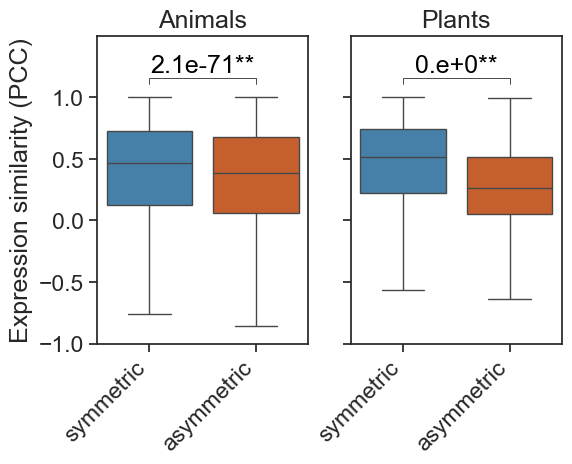

In [322]:
### All PCC
plot_subplots_barplot(df_exp, outfig1)


Animals p-va= 5.3e-113**
Plants p-va= 0.e+0**


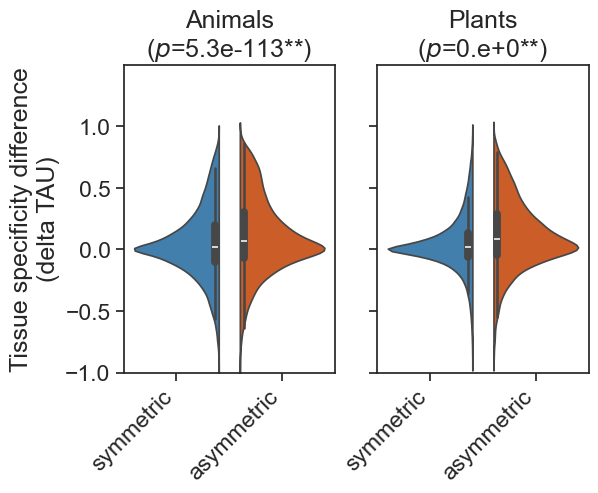

In [323]:
### All TAU
plot_subplots_violinplot(df_exp, outfig2)


In [324]:
### Create expression data supplementary table (3)
outexpPath = 'results/expr/tables_exp/'
files = [pccFilePlant, pccFileAnimal]
for f in files:
    keys = get_keys_hf5(f)
    for k in keys:
        n = k.replace('/','')
        df = pd.read_hdf(f, key=k)
        df.to_csv(outexpPath+n+'.csv', index=False)
    


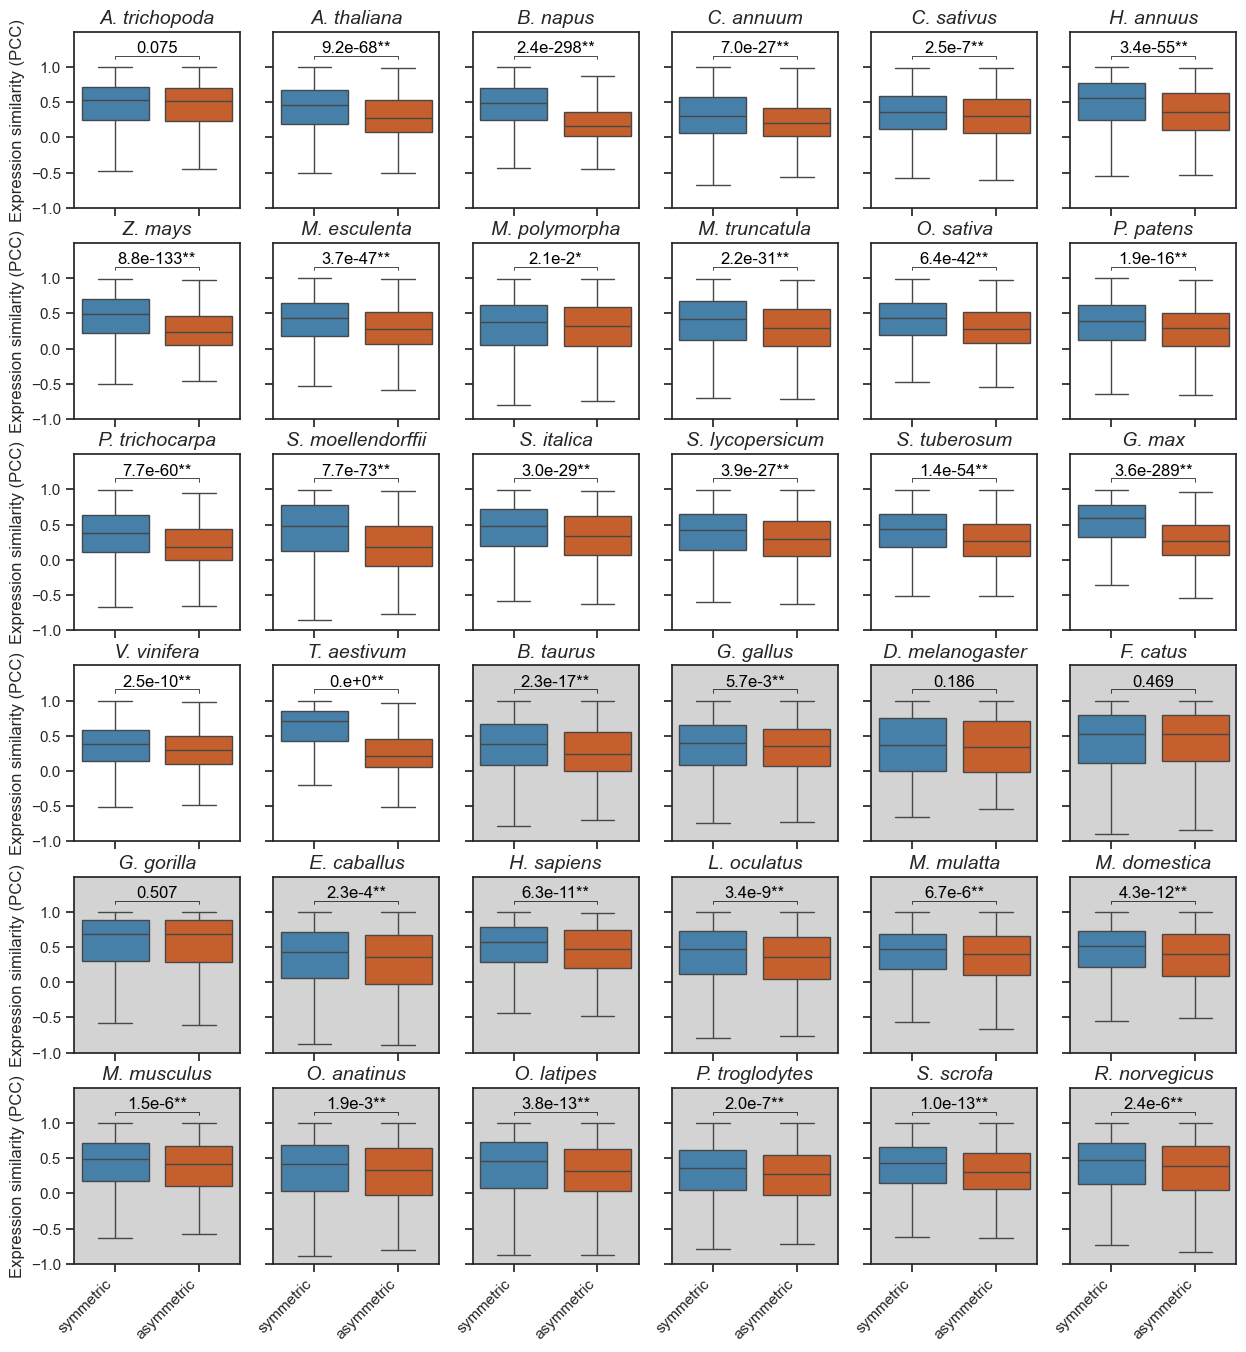

In [325]:
#### PCC species plot
taxa2name = load_taxa(prefFile)
plot_subplots_barplot_species(df_exp, outfig3, taxa2name)


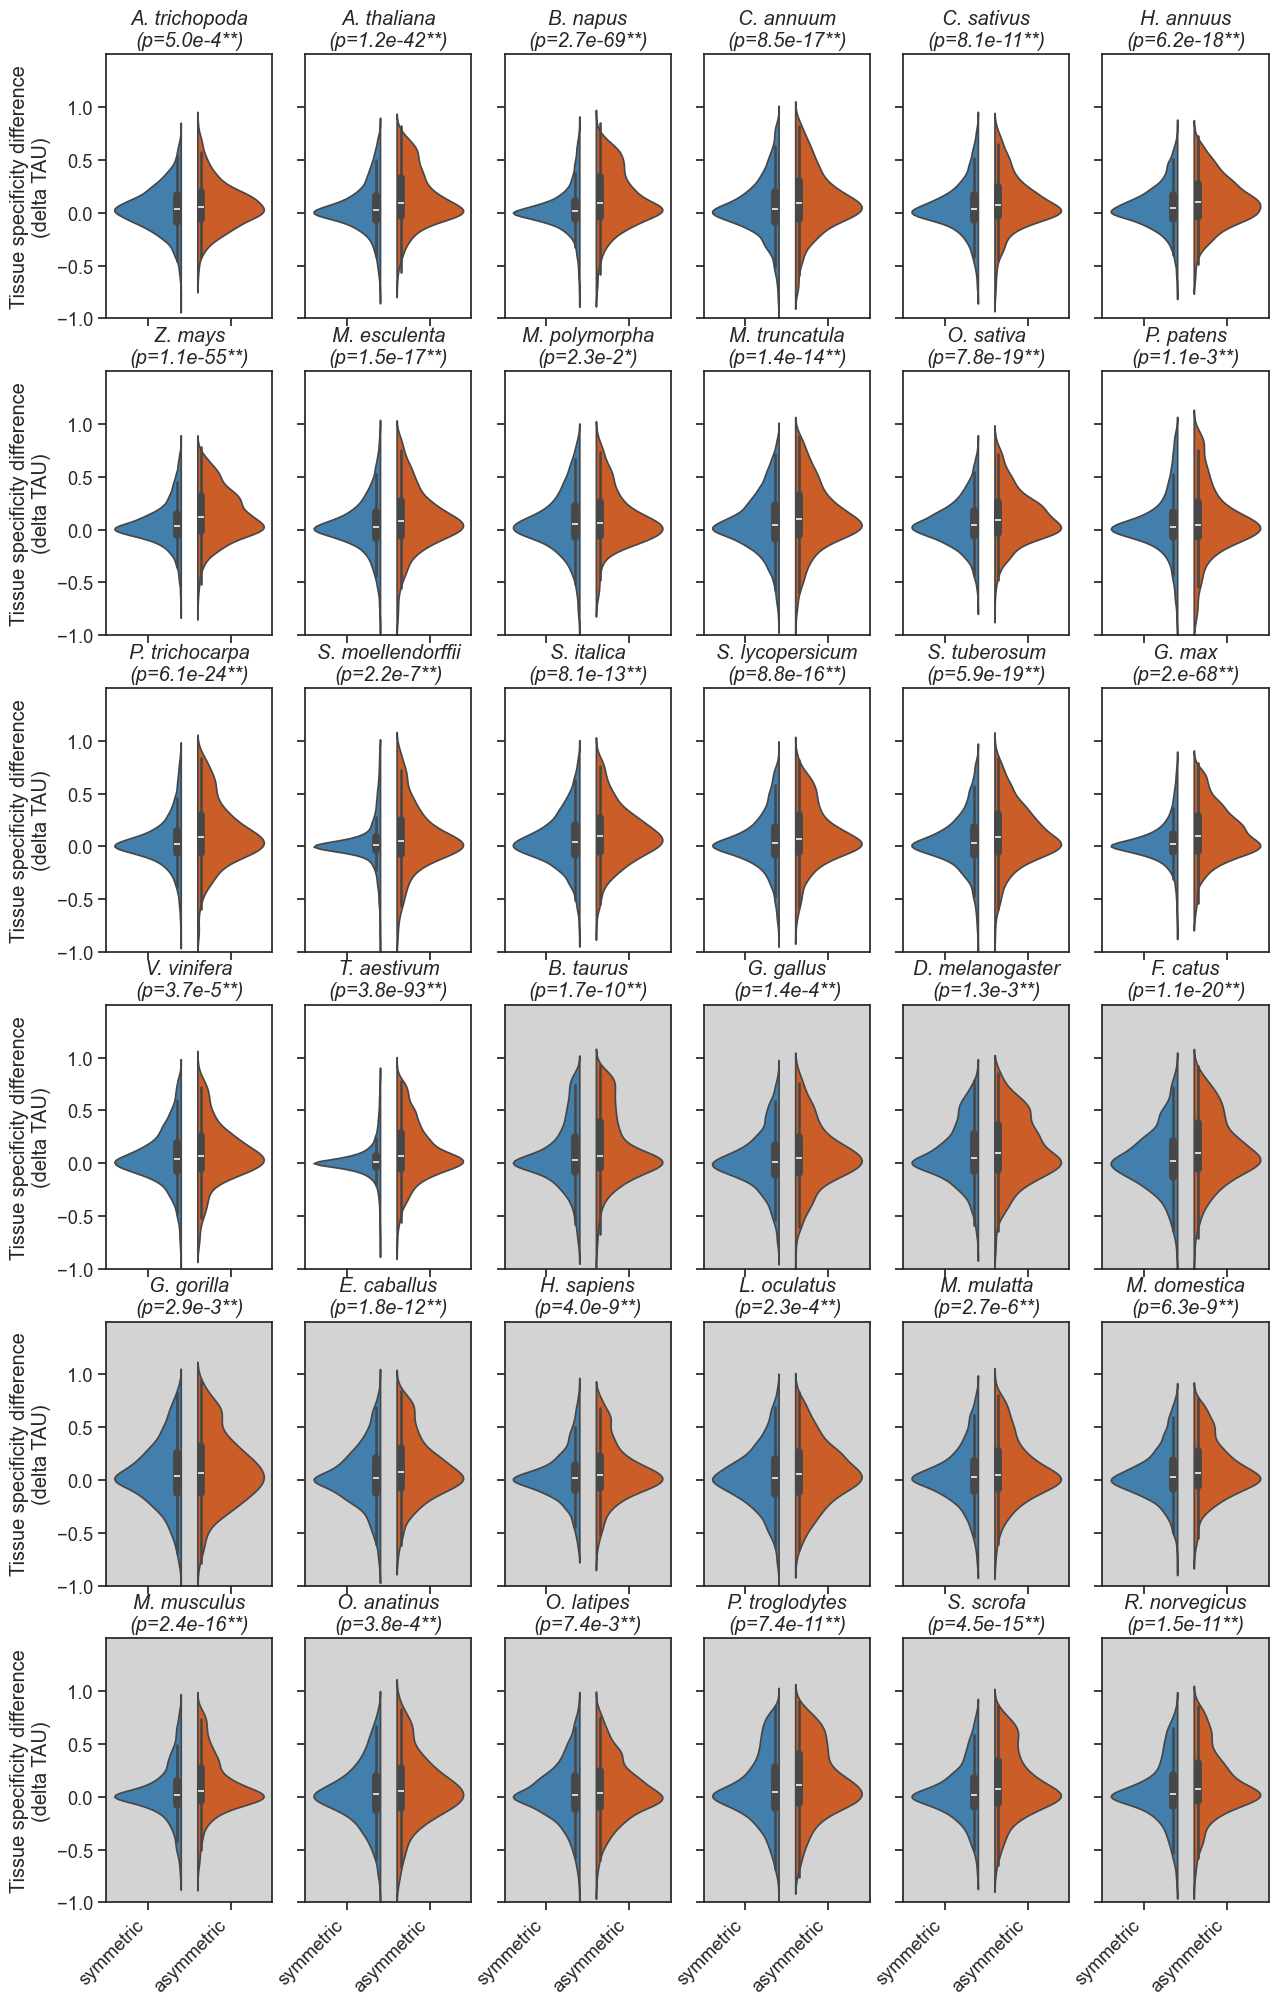

In [326]:
#### TAU species plot
plot_subplots_violinplot_species(df_exp, outfig4, taxa2name)


Internal median: 0.4011019794406684 0.29637003365555237
Terminal median: 0.6170622816878748 0.19569162123880052
Internal median: 0.4636318895412711 0.39575628306376665
Terminal median: 0.4673115730395067 0.30520215410859763


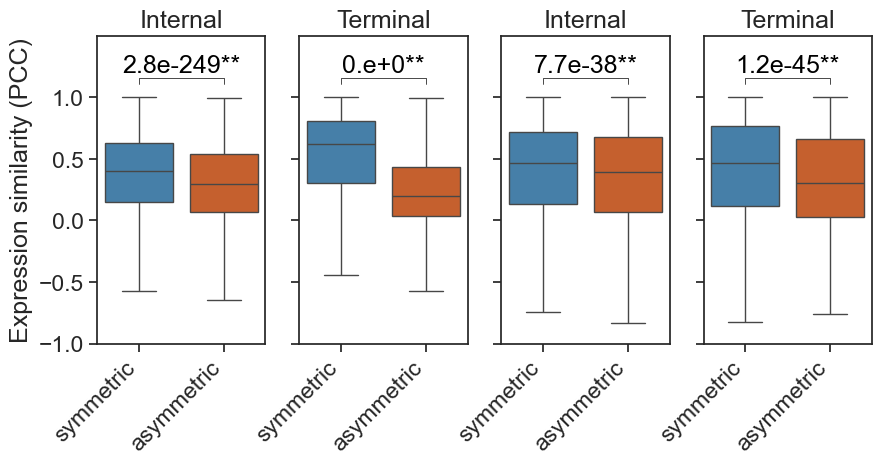

In [327]:
### PCC nodes internal terminal
plot_subplots_barplot_nodes(df_exp, outfig5)


Internal p-va= 7.7e-143**
Terminal p-va= 0.e+0**
Internal p-va= 4.5e-95**
Terminal p-va= 1.2e-22**


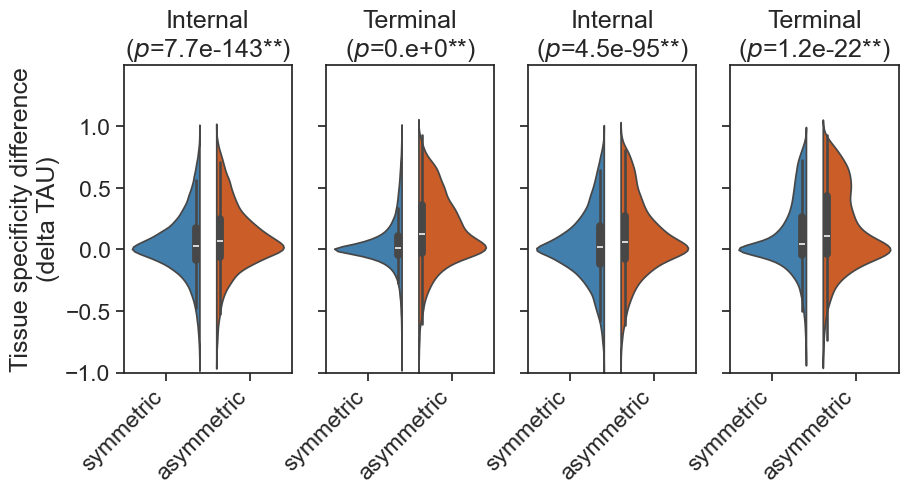

In [328]:
### TAU nodes internal terminal
plot_subplots_violinplot_nodes(df_exp,outfig6)


In [343]:
#### PCC

def flt_pcc_outgroup(df):
    samples = ['Plants', 'Animals']
    df = df.loc[(df['out_ldo_pcc_stat'].notnull()) & (df['out_mdo_pcc_stat'].notnull())] ### remove nan
    data = []
    for x,tag in enumerate(samples):
        df2 = df[df.sp_group == tag]
        sdf = df2[df2.symmetric].copy()
        adf = df2[~df2.symmetric].copy()
        ## Filters
        sdf = sdf.groupby('outgroup_species').filter(lambda x: len(x) >= 50) ### filter minimum amount of data in each outgroup and catergory
        adf = adf.groupby('outgroup_species').filter(lambda x: len(x) >= 50)
        count1 = sdf.groupby('outgroup_species')['out_ldo_pcc_stat'].transform('nunique')  ## filter rare values
        sdf = sdf[count1>2]
        count2 = sdf.groupby('outgroup_species')['out_mdo_pcc_stat'].transform('nunique')
        sdf = sdf[count2>2]
        count1 = adf.groupby('outgroup_species')['out_ldo_pcc_stat'].transform('nunique')
        adf = adf[count1>2]
        count2 = adf.groupby('outgroup_species')['out_mdo_pcc_stat'].transform('nunique')
        adf = adf[count2>2]
        data += [sdf, adf]
    df_flt = pd.concat(data,axis=0)
    return df_flt

##### TAU

def flt_tau_outgroup(df):
    samples = ['Plants', 'Animals'] 
    df['tau_l_o'] = df['ldo_tau'] - df['out_tau'] ## difference of tau
    df['tau_m_o'] = df['mdo_tau'] - df['out_tau']
    df = df.loc[(df['tau_l_o'].notnull()) & (df['tau_m_o'].notnull())] ### remove the nan values
    data = []
    for x,tag in enumerate(samples):
        df2 = df[df.sp_group == tag]
        sdf = df2[df2.symmetric].copy()
        adf = df2[~df2.symmetric].copy()
        ## Filters
        sdf = sdf.groupby('outgroup_species').filter(lambda x: len(x) >= 50) ### filter minimum amount of data in each outgroup and catergory
        adf = adf.groupby('outgroup_species').filter(lambda x: len(x) >= 50)
        count1 = sdf.groupby('outgroup_species')['tau_l_o'].transform('nunique')  ## filter rare values
        sdf = sdf[count1>2]
        count2 = sdf.groupby('outgroup_species')['tau_m_o'].transform('nunique')
        sdf = sdf[count2>2]
        count1 = adf.groupby('outgroup_species')['tau_l_o'].transform('nunique')
        adf = adf[count1>2]
        count2 = adf.groupby('outgroup_species')['tau_m_o'].transform('nunique')
        adf = adf[count2>2]
        data += [sdf, adf]
    df_flt = pd.concat(data,axis=0)
    return df_flt

### PLOTS

def plot_subplots_line_rna(df, time_dict, outfigname, data):
    sns.set(context='notebook', style='ticks', palette='deep', font='arial', font_scale=1.5, color_codes=False, rc=None)
    label_dict = {str(v):str(k[0])+'\n'+str(k[1]) for k, v in time_dict.items()}
    palette = ['#3182bdff','#e6550dff']
    samples = ['Plants', 'Animals']
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9,6), sharex=True, sharey=True)
    axes = axes.flatten()
    for x,tag in enumerate(samples):
        df2 = df[df.sp_group == tag]
        sdf = df2[df2.symmetric].copy()
        adf = df2[~df2.symmetric].copy()
                
        sns.lineplot(data=sdf, x="inum", y=data[0], markers=False, errorbar=('ci', 95), ax=axes[x], color=palette[0], dashes=(2,3))
        sns.lineplot(data=sdf, x="inum", y=data[1], markers=False, errorbar=('ci', 95), ax=axes[x], color=palette[0], dashes=(3,0))
        sns.lineplot(data=adf, x="inum", y=data[0], markers=False, errorbar=('ci', 95), ax=axes[x], color=palette[1], dashes=(2,3))
        sns.lineplot(data=adf, x="inum", y=data[1], markers=False, errorbar=('ci', 95), ax=axes[x], color=palette[1], dashes=(3,0))

        axes[x].set_title(tag)        
        axes[x].set_ylabel(data[2])
        axes[x].set_xlabel('Time interval (MYA)')
        
    ticks = [item.get_text() for item in axes[1].get_xticklabels()]
    new_ticks = [label_dict[x] if x in label_dict else '' for x in ticks]
    plt.gca().invert_xaxis()  
    plt.setp(axes, xticklabels=new_ticks)
    plt.savefig(outfigname+'_all.svg', bbox_inches='tight')
    plt.show()   

def plot_subplots_line_rna_species(df, taxa2name, time_dic, outfigname, data):
    sns.set(context='notebook', style='ticks', palette='deep', font='arial', font_scale=1, color_codes=False, rc=None)
    label_dic = {str(v):str(k[0])+'\n'+str(k[1]) for k, v in time_dic.items()}
    palette = ['#3182bdff','#e6550dff']
    print(f"initial number of species = {len(set(df.speciesF.values))}")
    ### Filter species that have less than 3 outgroup species
    count = df.groupby('speciesF')['outgroup_species'].transform('nunique')
    df = df[count>3].copy()
    print(f"filtered number of species = {len(set(df.speciesF.values))}")
    
    plants, animals = sorted(list(set(df[df.sp_group == 'Plants'].speciesF.values))),sorted(list(set(df[df.sp_group == 'Animals'].speciesF.values)))
    fig, axes = plt.subplots(nrows=7, ncols=4, figsize=(14,20), sharex=True, sharey=True) ## 7,4 - 6,5
    axes = axes.flatten()
    for x,tag in enumerate(plants+animals):
        name = taxa2name[tag].split(' ')[0][0]+'. '+taxa2name[tag].split(' ')[1]
        df2 = df.loc[(df['speciesF'] == tag)]
        sdf = df2[df2.symmetric].copy()
        adf = df2[~df2.symmetric].copy()
                
        sns.lineplot(data=sdf, x="inum", y=data[0], markers=False, errorbar=('ci', 95), ax=axes[x], color=palette[0], dashes=(2,3))
        sns.lineplot(data=sdf, x="inum", y=data[1], markers=False, errorbar=('ci', 95), ax=axes[x], color=palette[0], dashes=(3,0))
        sns.lineplot(data=adf, x="inum", y=data[0], markers=False, errorbar=('ci', 95), ax=axes[x], color=palette[1], dashes=(2,3))
        sns.lineplot(data=adf, x="inum", y=data[1], markers=False, errorbar=('ci', 95), ax=axes[x], color=palette[1], dashes=(3,0))
        
        axes[x].set_title(name, style='italic')
        axes[x].set_ylabel(data[2])
        axes[x].set_xlabel('Time interval (MYA)')
        if tag in animals:
            axes[x].set_facecolor('lightgray')

    ticks = [item.get_text() for item in axes[-1].get_xticklabels()]
    tickn = axes[-1].get_xticks()
    new_ticks = [label_dic[x] if x in label_dic else '' for x in ticks]
    new_ticks[-1] =''
    plt.setp(axes, xticks=tickn, xticklabels=new_ticks)
    # plt.setp(axes, xticklabels=new_ticks)
    plt.gca().invert_xaxis() 
    plt.savefig(outfigname+'_species.svg', bbox_inches='tight')
    plt.show()




In [330]:
### outgroup PCC
taxa2name = load_taxa(prefFile)
df_exp_p = get_data_h5(outFilePlant, 'Plants')
df_exp_a = get_data_h5(outFileAnimal, 'Animals')
df = pd.concat([df_exp_p,df_exp_a],axis=0)
df['tauV'] = df['mdo_tau'] - df['ldo_tau']
data = load_categories(df)

### get the dataframe
clase = ['symmetric','symmetric','symmetric','asymmetric','asymmetric','asymmetric'] ## order of data
dexp = merge_data_sym_asym(data, clase)



In [331]:
### Add time
dexp_time = add_time_dataframe(dexp, panterTimeFile, taxa2name)


6.36965 707.6047


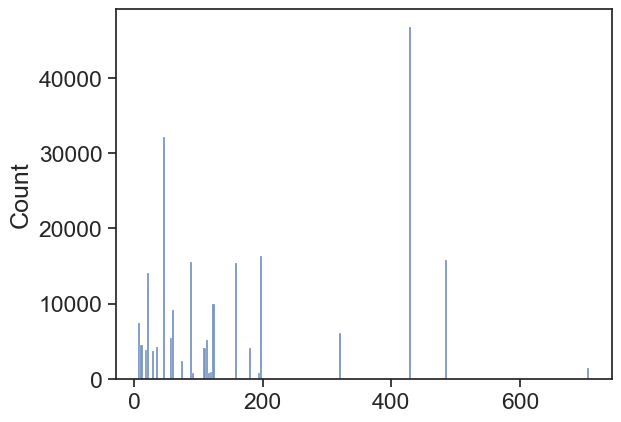

In [332]:
### create the intervals of time
times = sorted(dexp_time['time'].values)
print(times[0],times[-1])
sns.histplot(times, bins=200)  ### most of the times are in the range: 0-1000
plt.show()

In [333]:
intervals = [(x,x+50-1) for x in range(0,500,50)]
print(intervals)
time_dict = {x:y+1 for y,x in enumerate(intervals)}


[(0, 49), (50, 99), (100, 149), (150, 199), (200, 249), (250, 299), (300, 349), (350, 399), (400, 449), (450, 499)]


In [334]:
dexp_trange = add_time_interval(dexp_time, time_dict)
print(dexp.head())


        fam_id  fam_tail_idx  sp_tree_edge            sp_tree_tail  \
464372   10003           223           215  Bryophyta-Tracheophyta   
464373   10015           632           215  Bryophyta-Tracheophyta   
464390   10106           186           215  Bryophyta-Tracheophyta   
464435   10209           235           215  Bryophyta-Tracheophyta   
464484   10286           366           215  Bryophyta-Tracheophyta   

        sp_tree_head  ldo_fam_head_idx  mdo_fam_head_idx  ldo_branch_length  \
464372  Tracheophyta               309               225              0.147   
464373  Tracheophyta              1684               634              0.081   
464390  Tracheophyta               482               188              0.372   
464435  Tracheophyta              2053               237              0.228   
464484  Tracheophyta               368               458              0.040   

        mdo_branch_length  expected_branch_length  ...  out_mdo_pcc_stat  \
464372              0.292   

/tmp/ipykernel_5994/142840009.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.setp(axes, xticklabels=new_ticks)
/tmp/ipykernel_5994/142840009.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.setp(axes, xticklabels=new_ticks)


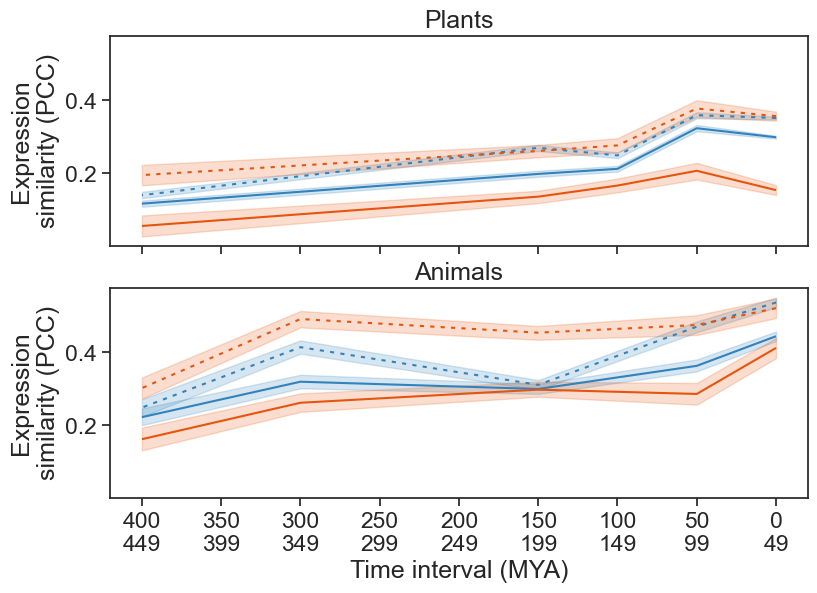

In [335]:
####Plot line PCC
## fiters:
dexp_pcc = flt_pcc_outgroup(dexp_trange)
## Plot
data=["out_ldo_pcc_stat", "out_mdo_pcc_stat",'Expression\nsimilarity (PCC)']
plot_subplots_line_rna(dexp_pcc, time_dict, outfig7, data)


initial number of species = 34
filtered number of species = 28


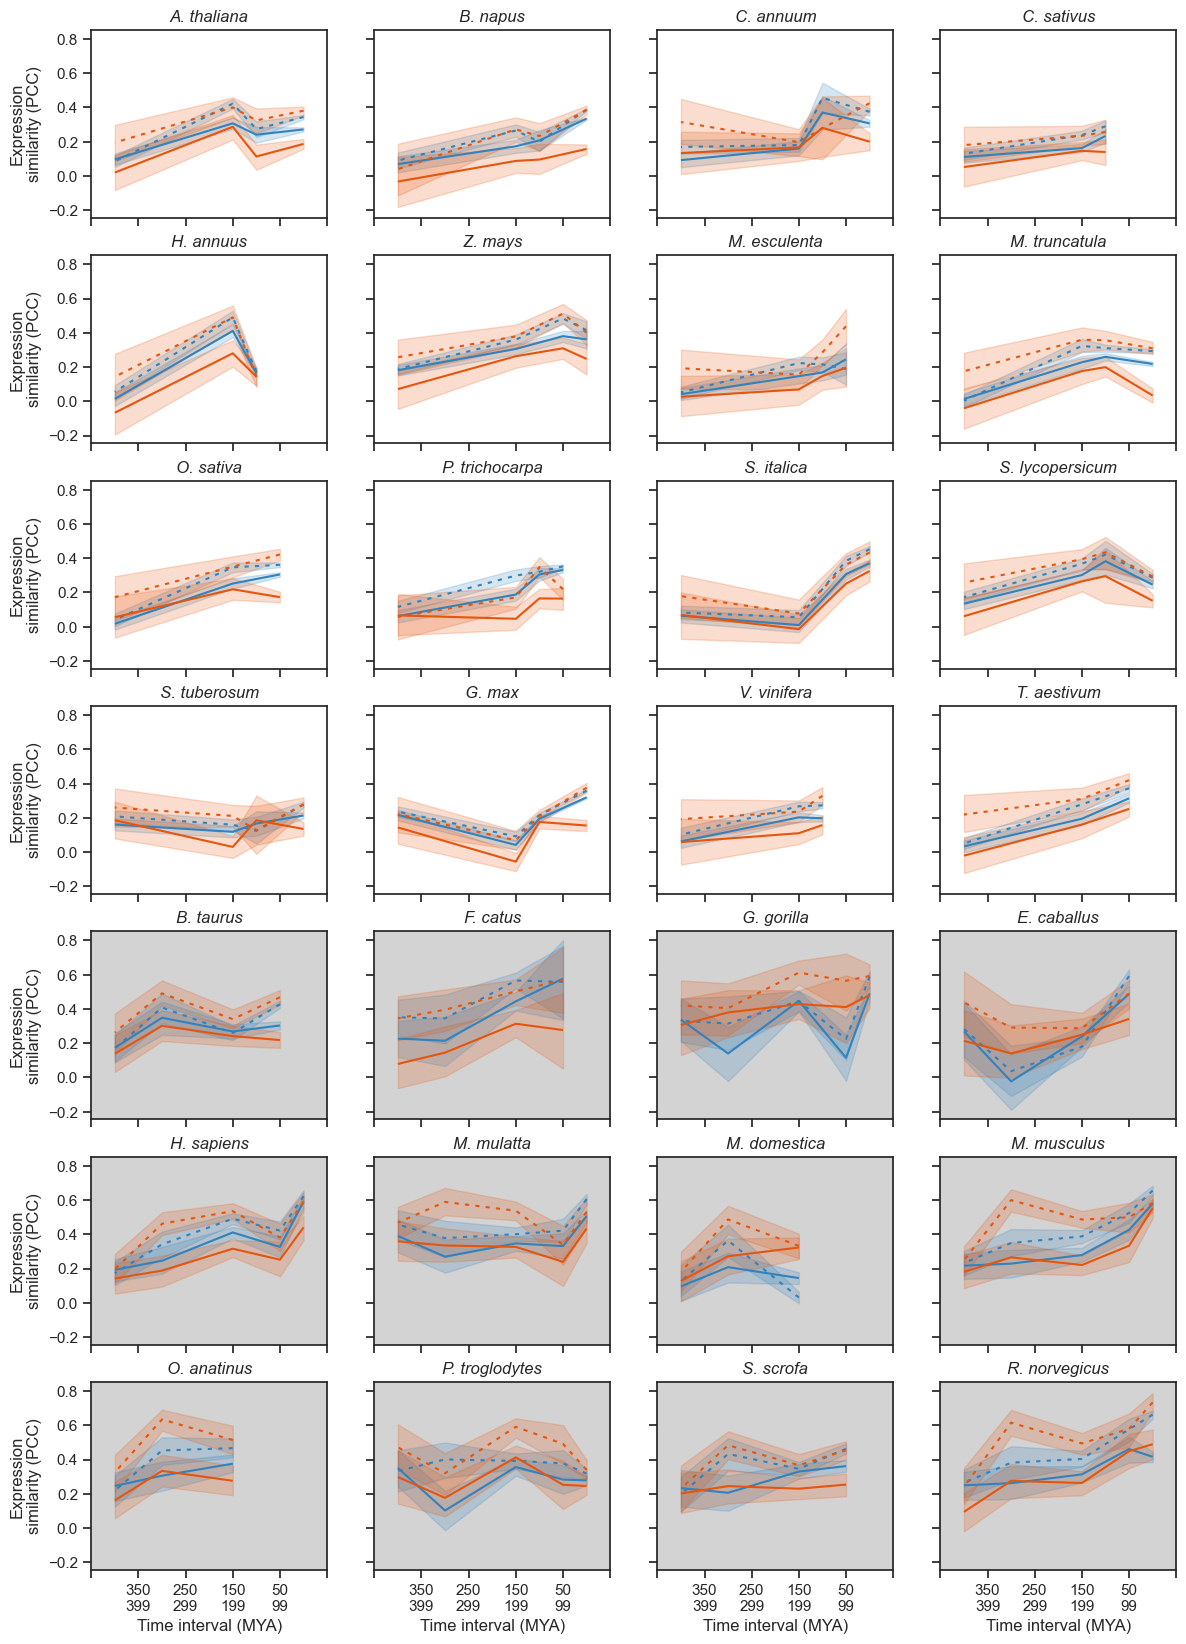

In [336]:

data=["out_ldo_pcc_stat", "out_mdo_pcc_stat",'Expression\nsimilarity (PCC)']
plot_subplots_line_rna_species(dexp_pcc, taxa2name, time_dict, outfig7, data)

/tmp/ipykernel_5994/1494870231.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.setp(axes, xticklabels=new_ticks)
/tmp/ipykernel_5994/1494870231.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.setp(axes, xticklabels=new_ticks)


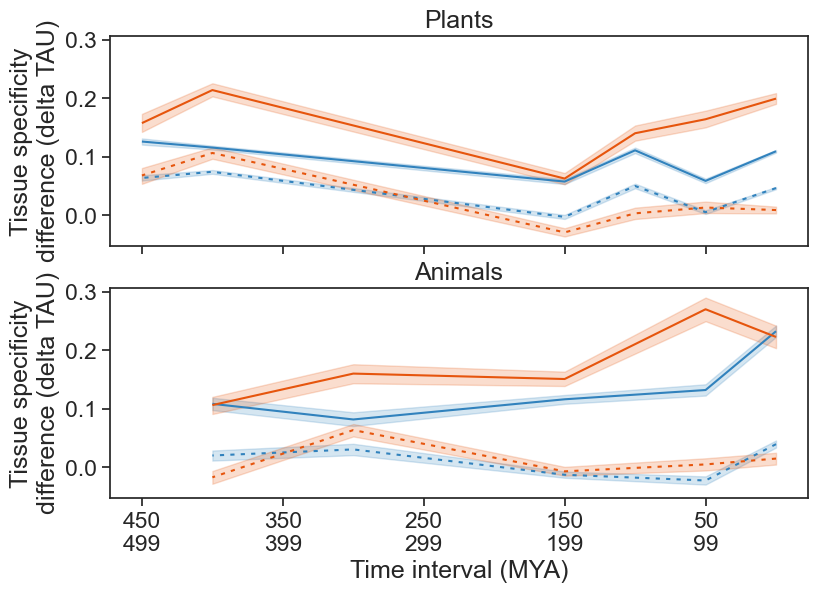

In [344]:
#### Plot TAU

## filter tau
dexp_tau = flt_tau_outgroup(dexp_trange)

## plot tau
data = ["tau_l_o","tau_m_o",'Tissue specificity\ndifference (delta TAU)']
plot_subplots_line_rna(dexp_tau, time_dict, outfig8, data)


initial number of species = 36
filtered number of species = 28


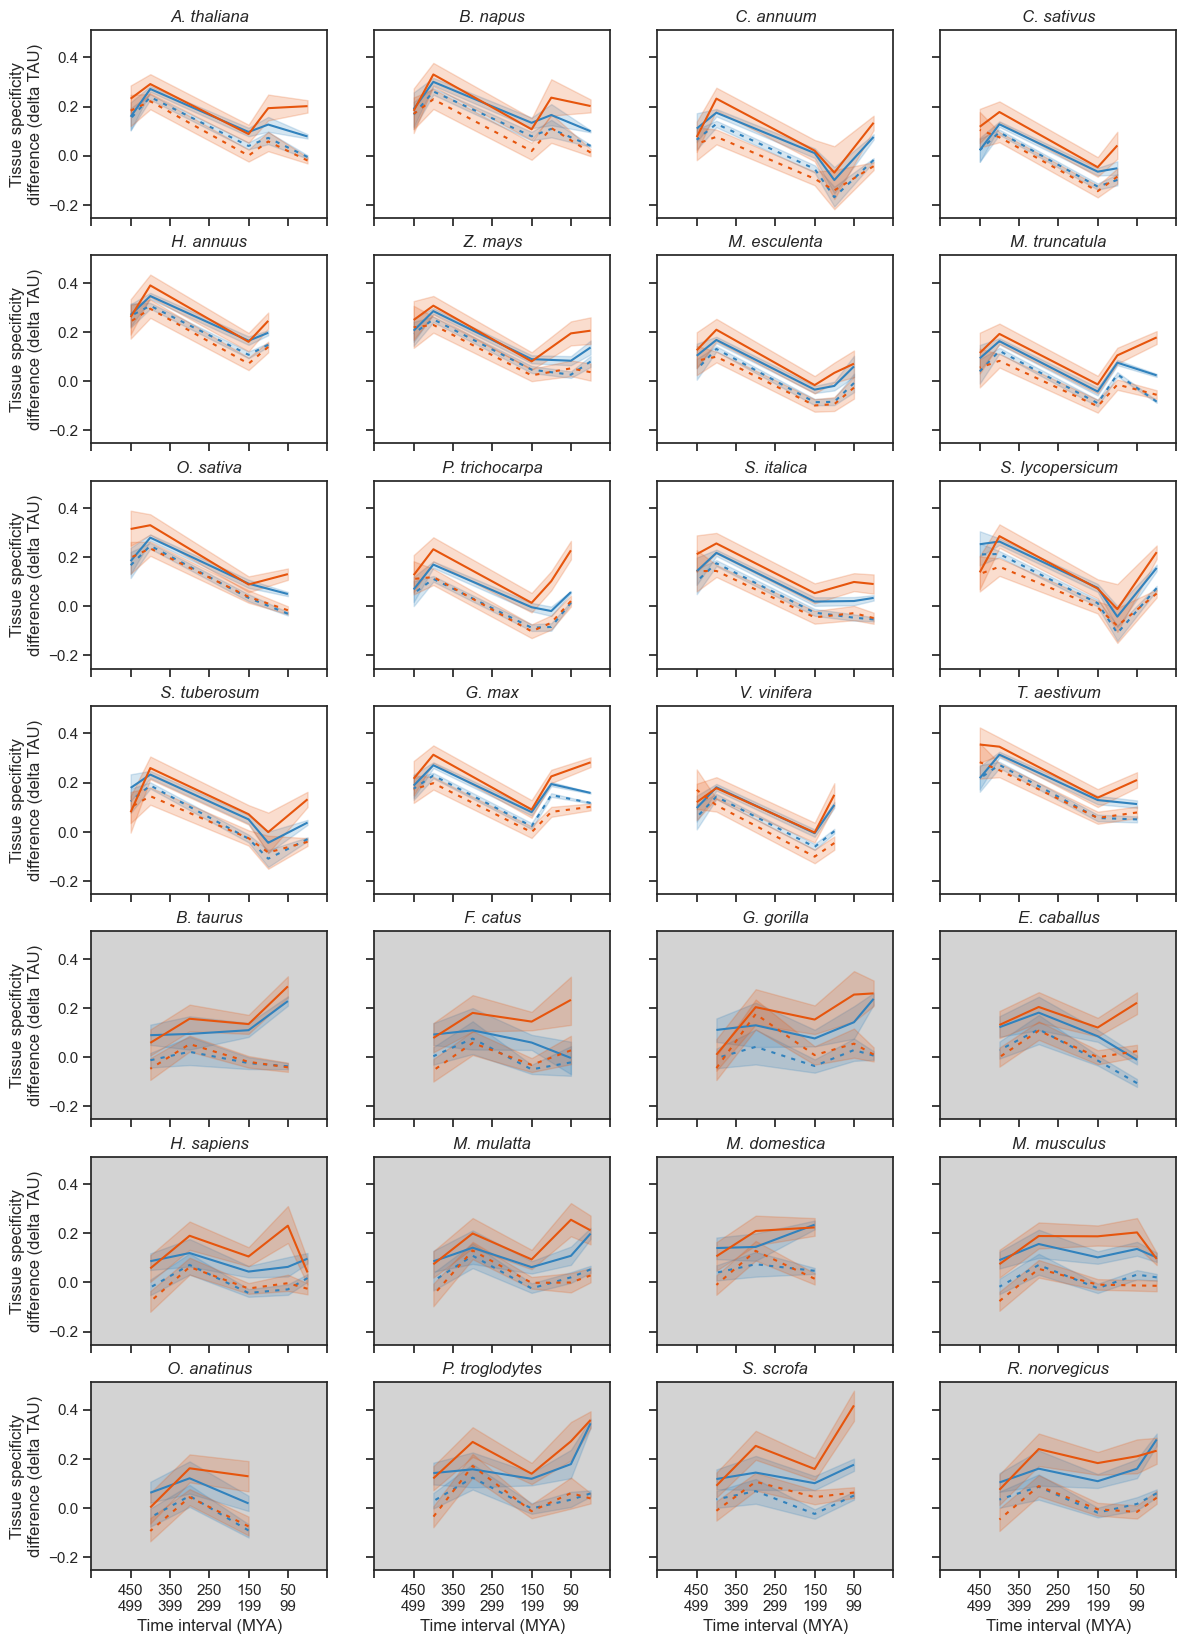

In [345]:

data = ["tau_l_o","tau_m_o",'Tissue specificity\ndifference (delta TAU)']
plot_subplots_line_rna_species(dexp_tau , taxa2name, time_dict, outfig8, data)

In [382]:
### Time leaves to check whether plants specific duplications are more recent
table = {'_'.join(pref2names[x].split(' ')):x for x in taxa2name}
t = ete3.Tree(panterTimeFile, format=1)
for leaf in t:
    leaf.name = table[leaf.name]
leaves = t.get_leaf_names()

nodes_dict = {x.name: x.dist for x in t.get_leaves()}

df3 = dexp[dexp.node_type] ## terminal
df3 = df3[df3.species.isin(leaves)]
df3['time'] = df3.species.map(nodes_dict)

animal = df3[df3.sp_group=='Animals'].time.values
plant = df3[df3.sp_group=='Plants'].time.values

print('Animals', len(animal), np.mean(list(set(animal))), np.median(list(set(animal))))
print('Plants',len(plant), np.mean(list(set(plant))), np.median(list(set(plant))))


Animals 22770 85.940045 45.3313
Plants 98958 136.75692272727272 56.7105
